In [277]:
import matplotlib.pyplot as plt
import pandas as pd

# 💾 Reading a text-based dataset into pandas

In [278]:
# read file into pandas using a relative path
sms_df = pd.read_csv("./spam.csv", encoding="latin-1")
sms_data_count = sms_df.shape[0]
print(f"sms data count: {sms_data_count}")
discord_df = pd.read_csv("./discord.csv", encoding="latin-1", sep = ";")
discord_data_count = discord_df.shape[0]
print(f"discord data count: {discord_data_count}")
discord_df.head()

sms data count: 5572
discord data count: 304


,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,spam,"""take nitro faster, its gonna begone now http...",NaN,NaN,NaN
1,spam,please join my awesome discord server which i...,NaN,NaN,NaN
2,spam,"""if you join the discrord server https://disc...",NaN,NaN,NaN
3,spam,"""hello, anyone interested in starting a new b...",NaN,NaN,NaN
4,spam,"""I have free nitro for you guys just click t...",NaN,NaN,NaN


In [279]:

df = pd.concat([sms_df, discord_df])

In [280]:
print(f"Row count before clean: {df.shape[0]}")
df = df.dropna(how="any", axis=1)
print(f"Row count after clean: {df.shape[0]}")

Row count before clean: 5876
Row count after clean: 5876


In [281]:
df.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [282]:

df.columns = ["label", "message"]

df.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


# 🔍 Exploratory Data Analysis (EDA)

In [283]:
df.describe()

,label,message
count,5876,5876
unique,2,5436
top,ham,"Sorry, I'll call later"
freq,4976,30


In [284]:
df.groupby("label").describe()

message                                                               
        count unique                                                top freq
label                                                                       
ham      4976   4667                             Sorry, I'll call later   30
spam      900    769  You won't believe it but it's true. It's Incre...    4

We have `4825` ham message and `747` spam message

In [285]:
# convert label to a numerical variable
df["label_num"] = df.label.map({"ham": 0, "spam": 1})
df.head()

,label,message,label_num
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0


> As we continue our analysis we want to start thinking about the features we are going to be using. This goes along with the general idea of feature engineering. The better your domain knowledge on the data, the better your ability to engineer more features from it. Feature engineering is a very large part of spam detection in general.

In [286]:
df["message_len"] = df.message.apply(len)
df.head()

,label,message,label_num,message_len
0,ham,"Go until jurong point, crazy.. Available only ...",0,111
1,ham,Ok lar... Joking wif u oni...,0,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1,155
3,ham,U dun say so early hor... U c already then say...,0,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",0,61


Text(0.5, 0, 'Message Length')

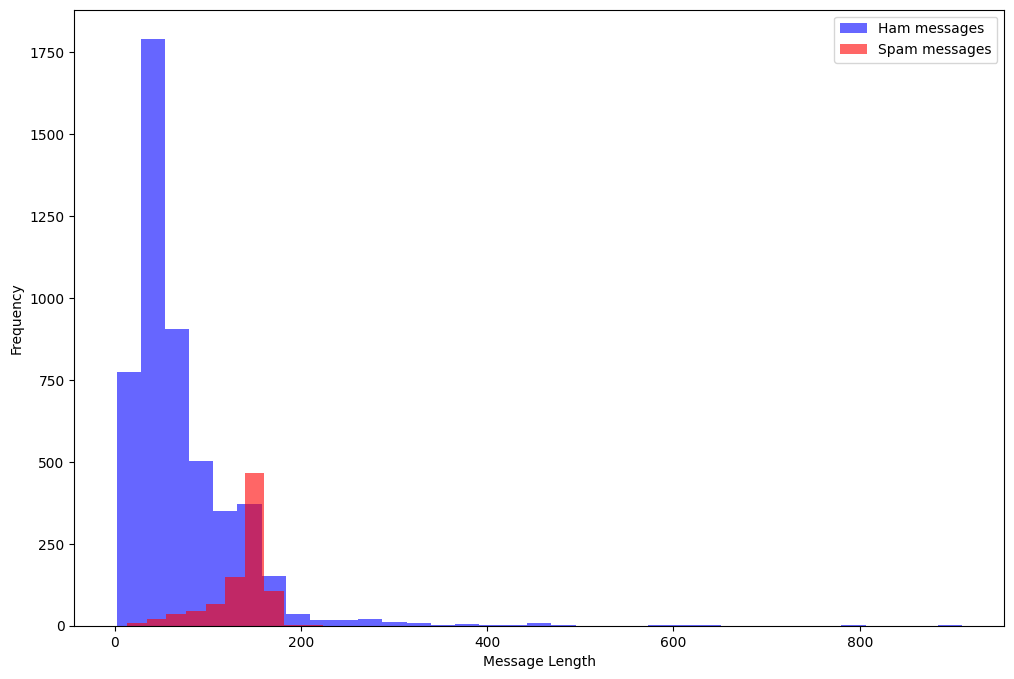

In [287]:
plt.figure(figsize=(12, 8))

df[df.label == "ham"].message_len.plot(
    bins=35, kind="hist", color="blue", label="Ham messages", alpha=0.6
)
df[df.label == "spam"].message_len.plot(
    kind="hist", color="red", label="Spam messages", alpha=0.6
)
plt.legend()
plt.xlabel("Message Length")

> Very interesting! Through just basic EDA we've been able to discover a trend that spam messages tend to have more characters.

In [288]:
df[df.label == "ham"].describe()

,label_num,message_len
count,4976.0,4976.000000
mean,0.0,70.355707
std,0.0,57.405616
min,0.0,2.000000
25%,0.0,33.000000
50%,0.0,52.000000
75%,0.0,90.000000
max,0.0,910.000000


In [289]:
df[df.label == "spam"].describe()

,label_num,message_len
count,900.0,900.000000
mean,1.0,137.542222
std,0.0,30.249489
min,1.0,13.000000
25%,1.0,129.750000
50%,1.0,149.000000
75%,1.0,158.000000
max,1.0,224.000000


> Woah! 910 characters, let's use masking to find this message:

In [290]:
df[df.message_len == 910].message.iloc[0]

"For me the love should start with attraction.i should feel that I need her every time around me.she should be the first thing which comes in my thoughts.I would start the day and end it with her.she should be there every time I dream.love will be then when my every breath has her name.my life should happen around her.my life will be named to her.I would cry for her.will give all my happiness and take all her sorrows.I will be ready to fight with anyone for her.I will be in love when I will be doing the craziest things for her.love will be when I don't have to proove anyone that my girl is the most beautiful lady on the whole planet.I will always be singing praises for her.love will be when I start up making chicken curry and end up makiing sambar.life will be the most beautiful then.will get every morning and thank god for the day because she is with me.I would like to say a lot..will tell later.."

# 📑 Text Pre-processing


In [291]:
import string
import nltk

nltk.download("stopwords")
from nltk.corpus import stopwords


def text_process(mess):
    """
    Takes in a string of text, then performs the following:
    1. Remove all punctuation
    2. Remove all stopwords
    3. Returns a list of the cleaned text
    """
    STOPWORDS = stopwords.words("english") + [
        "u",
        "ü",
        "ur",
        "4",
        "2",
        "im",
        "dont",
        "doin",
        "ure",
    ]
    # Check characters to see if they are in punctuation
    nopunc = [char for char in mess if char not in string.punctuation]

    # Join the characters again to form the string.
    nopunc = "".join(nopunc)

    # Now just remove any stopwords
    return " ".join([word for word in nopunc.split() if word.lower() not in STOPWORDS])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [292]:
df.head()

,label,message,label_num,message_len
0,ham,"Go until jurong point, crazy.. Available only ...",0,111
1,ham,Ok lar... Joking wif u oni...,0,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1,155
3,ham,U dun say so early hor... U c already then say...,0,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",0,61


> Now let's "tokenize" these messages. Tokenization is just the term used to describe the process of converting the normal text strings in to a list of tokens (words that we actually want).

In [293]:
df["clean_msg"] = df.message.apply(text_process)

df.head()

,label,message,label_num,message_len,clean_msg
0,ham,"Go until jurong point, crazy.. Available only ...",0,111,Go jurong point crazy Available bugis n great ...
1,ham,Ok lar... Joking wif u oni...,0,29,Ok lar Joking wif oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1,155,Free entry wkly comp win FA Cup final tkts 21s...
3,ham,U dun say so early hor... U c already then say...,0,49,dun say early hor c already say
4,ham,"Nah I don't think he goes to usf, he lives aro...",0,61,Nah think goes usf lives around though


In [294]:
type(stopwords.words("english"))

list

In [295]:
from collections import Counter

words = df[df.label == "ham"].clean_msg.apply(
    lambda x: [word.lower() for word in x.split()]
)
ham_words = Counter()

for msg in words:
    ham_words.update(msg)

print(ham_words.most_common(50))

[('get', 307), ('ltgt', 276), ('ok', 273), ('go', 249), ('know', 239), ('got', 237), ('ill', 237), ('like', 236), ('call', 229), ('good', 227), ('come', 225), ('time', 192), ('day', 191), ('love', 186), ('going', 170), ('want', 167), ('one', 165), ('home', 160), ('lor', 160), ('need', 157), ('sorry', 153), ('still', 148), ('see', 139), ('later', 135), ('n', 134), ('r', 132), ('think', 131), ('da', 131), ('today', 130), ('back', 130), ('well', 129), ('send', 123), ('tell', 121), ('cant', 119), ('hi', 118), ('ì', 117), ('much', 116), ('take', 112), ('oh', 112), ('hey', 108), ('great', 107), ('night', 107), ('happy', 106), ('way', 104), ('work', 103), ('thats', 101), ('hope', 100), ('pls', 98), ('say', 96), ('wat', 95)]


In [296]:
words = df[df.label == "spam"].clean_msg.apply(
    lambda x: [word.lower() for word in x.split()]
)
spam_words = Counter()

for msg in words:
    spam_words.update(msg)

print(spam_words.most_common(50))

[('call', 394), ('free', 277), ('txt', 170), ('mobile', 143), ('claim', 135), ('text', 133), ('stop', 124), ('reply', 118), ('prize', 110), ('get', 95), ('new', 80), ('send', 73), ('win', 71), ('cash', 71), ('nokia', 70), ('service', 70), ('contact', 66), ('urgent', 65), ('customer', 62), ('please', 62), ('guaranteed', 60), ('week', 54), ('16', 53), ('per', 52), ('tone', 52), ('phone', 50), ('18', 49), ('draw', 45), ('awarded', 44), ('chat', 44), ('latest', 40), ('mins', 40), ('message', 39), ('receive', 38), ('code', 38), ('camera', 38), ('1', 38), ('go', 37), ('line', 37), ('shows', 36), ('150ppm', 36), ('holiday', 36), ('landline', 36), ('å£1000', 35), ('number', 35), ('every', 35), ('ringtone', 34), ('po', 34), ('box', 34), ('selected', 33)]


# Splitting between SMS and discord data

In [297]:
# split data again after preprocessing
sms_df = df.head(sms_data_count)
discord_df = df.tail(discord_data_count)

In [298]:
discord_df.head()

,label,message,label_num,message_len,clean_msg
0,spam,"""take nitro faster, its gonna begone now http...",1,81,take nitro faster gonna begone httpsdiscordngi...
1,spam,please join my awesome discord server which i...,1,96,please join awesome discord server better one ...
2,spam,"""if you join the discrord server https://disc...",1,93,join discrord server httpsdiscordggda8KgGwb ge...
3,spam,"""hello, anyone interested in starting a new b...",1,131,hello anyone interested starting new business ...
4,spam,"""I have free nitro for you guys just click t...",1,114,free nitro guys click link httpsdiscordngiftAc...


# 🧮 Vectorization


In [299]:
# split X and y into training and testing sets
from sklearn.model_selection import train_test_split

# how to define X and y (from the SMS data) for use with COUNTVECTORIZER
X = sms_df.clean_msg
y = sms_df.label_num
print(X.shape)
print(y.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, test_size=0.2)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(5572,)
(5572,)
(4457,)
(1115,)
(4457,)
(1115,)


In [300]:
print(type(X_test))
print(X_test.iloc[0])
print(X_test.iloc[1])

<class 'pandas.core.series.Series'>
Convey regards
Û anyway many good evenings


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

# instantiate the vectorizer
vect = CountVectorizer()
vect.fit(X_train)

# learn training data vocabulary, then use it to create a document-term matrix
X_train_dtm = vect.transform(X_train)

# equivalently: combine fit and transform into a single step
X_train_dtm = vect.fit_transform(X_train)


# examine the document-term matrix
print(type(X_train_dtm), X_train_dtm.shape)

# transform testing data (using fitted vocabulary) into a document-term matrix
X_test_dtm = vect.transform(X_test)
print(type(X_test_dtm), X_test_dtm.shape)

In [ ]:
from joblib import dump, load

dump(vect, "vect.joblib")

In [ ]:
print(type(X_train))
print(X_train.iloc[0])
print(X_train.iloc[1])
print(X_train.iloc[2])
print(X_train.iloc[3])

In [ ]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer = TfidfTransformer()
tfidf_transformer.fit(X_train_dtm)
tfidf_transformer.transform(X_train_dtm)

# 🤖 Building and evaluating a model

> We will use [multinomial Naive Bayes](http://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html):

> The multinomial Naive Bayes classifier is suitable for classification with **discrete features** (e.g., word counts for text classification). The multinomial distribution normally requires integer feature counts. However, in practice, fractional counts such as tf-idf may also work.

In [ ]:
# import and instantiate a Multinomial Naive Bayes model
from sklearn.naive_bayes import MultinomialNB

nb = MultinomialNB()

In [ ]:
# train the model using X_train_dtm (timing it with an IPython "magic command")
%time nb.fit(X_train_dtm, y_train)

In [ ]:
from sklearn import metrics

# make class predictions for X_test_dtm
y_pred_class = nb.predict(X_test_dtm)

# calculate accuracy of class predictions
print("=======Accuracy Score===========")
print(metrics.accuracy_score(y_test, y_pred_class))

# print the confusion matrix
print("=======Confision Matrix===========")
metrics.confusion_matrix(y_test, y_pred_class)

In [ ]:
# print message text for false positives (ham incorrectly classifier)
# X_test[(y_pred_class==1) & (y_test==0)]
X_test[y_pred_class > y_test]

In [ ]:
# print message text for false negatives (spam incorrectly classifier)
X_test[y_pred_class < y_test]

In [ ]:
# calculate predicted probabilities for X_test_dtm (poorly calibrated)
y_pred_prob = nb.predict_proba(X_test_dtm)[:, 1]
y_pred_prob

In [ ]:
# calculate AUC
metrics.roc_auc_score(y_test, y_pred_prob)

In [ ]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline

pipe = Pipeline(
    [
        ("bow", CountVectorizer()),
        ("tfid", TfidfTransformer()),
        ("model", MultinomialNB()),
    ]
)

pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)

# calculate accuracy of class predictions
print("=======Accuracy Score===========")
print(metrics.accuracy_score(y_test, y_pred))

# print the confusion matrix
print("=======Confision Matrix===========")
metrics.confusion_matrix(y_test, y_pred)

In [ ]:
# Saving Model
from joblib import dump, load

# https://scikit-learn.org/stable/model_persistence.html
dump(nb, "nb_model.joblib")

# Testing On Discord Dataset


In [ ]:
X_test = discord_df.clean_msg
y_test = discord_df.label_num
# turn message into count vectorizer
X_test_dtm = vect.transform(X_test)

In [ ]:
y_pred = nb.predict(X_test_dtm)
print(len(y_pred))
print("=======Accuracy Score===========")
print(metrics.accuracy_score(y_test, y_pred))
# print the confusion matrix
print("=======Confision Matrix===========")
print(metrics.confusion_matrix(y_test, y_pred))

# 📊 Comparing models

We will compare multinomial Naive Bayes with [logistic regression](http://scikit-learn.org/stable/modules/linear_model.html#logistic-regression):

> Logistic regression, despite its name, is a **linear model for classification** rather than regression. Logistic regression is also known in the literature as logit regression, maximum-entropy classification (MaxEnt) or the log-linear classifier. In this model, the probabilities describing the possible outcomes of a single trial are modeled using a logistic function.

In [ ]:
# import an instantiate a logistic regression model
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(solver="liblinear")

# train the model using X_train_dtm
%time logreg.fit(X_train_dtm, y_train)

In [ ]:
# make class predictions for X_test_dtm
y_pred_class = logreg.predict(X_test_dtm)

# calculate predicted probabilities for X_test_dtm (well calibrated)
y_pred_prob = logreg.predict_proba(X_test_dtm)[:, 1]
y_pred_prob

In [ ]:
# calculate accuracy of class predictions
print("=======Accuracy Score===========")
print(metrics.accuracy_score(y_test, y_pred_class))

# print the confusion matrix
print("=======Confision Matrix===========")
print(metrics.confusion_matrix(y_test, y_pred_class))

# calculate AUC
print("=======ROC AUC Score===========")
print(metrics.roc_auc_score(y_test, y_pred_prob))

# 🧮 Tuning the vectorizer

Thus far, we have been using the default parameters of [CountVectorizer:](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html)

In [ ]:
# show default parameters for CountVectorizer
vect

> 📌 However, the vectorizer is worth tuning, just like a model is worth tuning! Here are a few parameters that you might want to tune:

> - 📌 **stop_words**: string {'english'}, list, or None (default)
    - If 'english', a built-in stop word list for English is used.
    - If a list, that list is assumed to contain stop words, all of which will be removed from the resulting tokens.
    - If None, no stop words will be used.

In [ ]:
# remove English stop words
vect = CountVectorizer(stop_words="english")

> - 📌 **ngram_range**: tuple (min_n, max_n), default=(1, 1)
    - The lower and upper boundary of the range of n-values for different n-grams to be extracted.
    - All values of n such that min_n <= n <= max_n will be used.

In [ ]:
# include 1-grams and 2-grams
vect = CountVectorizer(ngram_range=(1, 2))

> - 📌 **max_df**: float in range [0.0, 1.0] or int, default=1.0
    - When building the vocabulary, ignore terms that have a document frequency strictly higher than the given threshold (corpus-specific stop words).
    - If float, the parameter represents a proportion of documents.
    - If integer, the parameter represents an absolute count.

In [ ]:
# ignore terms that appear in more than 50% of the documents
vect = CountVectorizer(max_df=0.5)

> - 📌 **min_df**: float in range [0.0, 1.0] or int, default=1
    - When building the vocabulary, ignore terms that have a document frequency strictly lower than the given threshold. (This value is also called "cut-off" in the literature.)
    - If float, the parameter represents a proportion of documents.
    - If integer, the parameter represents an absolute count.

In [ ]:
# only keep terms that appear in at least 2 documents
vect = CountVectorizer(min_df=2)

> - 📌 **Guidelines for tuning CountVectorizer**:
    - Use your knowledge of the problem and the text, and your understanding of the tuning parameters, to help you decide what parameters to tune and how to tune them.
    - Experiment, and let the data tell you the best approach!